## POS tagging using modified Viterbi

Objectives of the analysis -
- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 

- Solve the problem of unknown words using at least two techniques. 

- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.

- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were 
incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re
import requests
import random
import numpy as np
import pandas as pd
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\SRINU\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SRINU\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# let's print few of the tagged data
print(nltk_data[:5])


[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Training Set Length -", len(test_set))
print("-" * 125)
print("Training Data Glimpse -\n")
print(train_set[:5])

Training Set Length - 3718
Training Set Length - 196
-----------------------------------------------------------------------------------------------------------------------------
Training Data Glimpse -

[[('Bribe', 'NOUN'), ('by', 'ADP'), ('bribe', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Sternberg', 'NOUN'), ('and', 'CONJ'), ('his', 'PRON'), ('co-author', 'NOUN'), (',', '.'), ('Matthew', 'NOUN'), ('C.', 'NOUN'), ('Harrison', 'NOUN'), ('Jr.', 'NOUN'), (',', '.'), ('lead', 'VERB'), ('us', 'PRON'), ('along', 'ADP'), ('the', 'DET'), ('path', 'NOUN'), ('0', 'X'), ('Wedtech', 'NOUN'), ('traveled', 'VERB'), ('*T*-1', 'X'), (',', '.'), ('from', 'ADP'), ('its', 'PRON'), ('inception', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('small', 'ADJ'), ('manufacturing', 'VERB'), ('company', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('status', 'NOUN'), ('of', 'ADP'), ('full-fledged', 'ADJ'), ('defense', 'NOUN'), ('contractor', 'NOUN'), (',', '.'), ('entrusted', 'VERB'), ('*', 'X'), ('with', 'ADP'), ('the', 'DE

In [6]:
# function to extract nested tuple value

def get_nested_tuple_from_list(input_list, index):
    if index == -1:
        return [tup for sent in input_list for tup in sent]
    else:
        return [tup[index] for sent in input_list for tup in sent]

In [7]:
# function to extract value from tuple by index position

def get_tuple_value_from_list(input_list, index):
    if index == -1:
        return [pair for pair in input_list]
    else:
        return [pair[index] for pair in input_list]
    

In [8]:
# function to convert list to set object

def convert_list_to_set(input_list):
    return set(input_list)

In [9]:
# function to get values from set

def get_value_from_set(input_set):
    return [res for res in input_set]

In [10]:
# function to convert tuple value to list

def get_list_from_tuple_values(input_tuple, index):
    return list(set(get_tuple_value_from_list(input_tuple, index)))

In [11]:
# get's the list of training set tagged words and print top 10

training_tagged_words = get_nested_tuple_from_list(train_set, -1)

print('Total tagged words in training set :', len(training_tagged_words))
print('-' * 125)
print('Top 10 tagged words in training set :', training_tagged_words[:10])

Total tagged words in training set : 95849
-----------------------------------------------------------------------------------------------------------------------------
Top 10 tagged words in training set : [('Bribe', 'NOUN'), ('by', 'ADP'), ('bribe', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Sternberg', 'NOUN'), ('and', 'CONJ'), ('his', 'PRON'), ('co-author', 'NOUN'), (',', '.')]


In [12]:
# extracting top 10 tokens from the training_tagged_words

training_data_tokens = get_tuple_value_from_list(training_tagged_words, 0)

print('Top 10 tagged words:', training_data_tokens[:10])

Top 10 tagged words: ['Bribe', 'by', 'bribe', ',', 'Mr.', 'Sternberg', 'and', 'his', 'co-author', ',']


In [13]:
# extracting top 10 POS tags for the training_tagged_words

training_data_pos_tags = get_tuple_value_from_list(training_tagged_words, 1)

print('Top 10 POS tags :', training_data_pos_tags[:10])

Top 10 POS tags : ['NOUN', 'ADP', 'NOUN', '.', 'NOUN', 'NOUN', 'CONJ', 'PRON', 'NOUN', '.']


In [14]:
# building the train vocabulary set from training data tokens

training_vocabulary_set = convert_list_to_set(training_data_tokens)

print('Top 10 vocabulary: ', get_value_from_set(training_vocabulary_set)[:10])

Top 10 vocabulary:  ['*T*-31', 'entangled', 'questioned', 'industry', 'Colo.', 'communications', 'arrival', 'quickly', '*T*-32', 'ITC']


In [15]:
# converting train POS tags to a set

training_pos_tag_set = convert_list_to_set(training_data_pos_tags)

print('Top 10 POS tags: ', get_value_from_set(training_pos_tag_set)[:10])

Top 10 POS tags:  ['PRON', '.', 'NUM', 'PRT', 'CONJ', 'NOUN', 'VERB', 'ADJ', 'ADV', 'DET']


In [16]:
print("Length of Vocabulary:", len(training_vocabulary_set))
print("Length of POS Tags:", len(training_pos_tag_set)) 
print("Available POS Tags:", training_pos_tag_set) 

Length of Vocabulary: 12091
Length of POS Tags: 12
Available POS Tags: {'PRON', '.', 'NUM', 'PRT', 'CONJ', 'NOUN', 'VERB', 'ADJ', 'ADV', 'DET', 'X', 'ADP'}


### 2. POS Tagging Algorithm - HMM

Hidden Markov Model based algorithm is used to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun.

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero

### Emission Probabilities (i.e. probability of a word given a tag)

In [17]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocabulary = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocabulary))

In [18]:
# compute Emission Probability(word given tag): 

def emission_probability_word_given_tag(word, tag, training_bag = training_tagged_words):
    tag_list = [pair for pair in training_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities (i.e. probability of getting a tag t2 given that the tag for previous word was t1)

In [19]:
# compute Transition Probability (tag given tag: tag2(t2) given tag1 (t1))

def transition_probability_t2_given_t1(t2, t1, training_bag = training_tagged_words):
    tags = [pair[1] for pair in training_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index] == t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [20]:
# creating t x t transition matrix of tags

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = transition_probability_t2_given_t1(t2, t1)[0]/transition_probability_t2_given_t1(t2, t1)[1]

# Let's have a glimpse into the transition matrix
tags_matrix

array([[8.05214699e-03, 4.06441726e-02, 7.28527596e-03, 1.26533741e-02,
        4.98466240e-03, 2.09355831e-01, 4.82745409e-01, 7.40030706e-02,
        3.52760740e-02, 9.20245424e-03, 9.35582817e-02, 2.22392641e-02],
       [6.58709481e-02, 9.33321342e-02, 8.07681978e-02, 2.51278840e-03,
        5.87812960e-02, 2.22022802e-01, 8.83065611e-02, 4.42430228e-02,
        5.37557229e-02, 1.72395229e-01, 2.62047928e-02, 9.17167738e-02],
       [1.78571430e-03, 1.14583336e-01, 1.83333337e-01, 2.73809526e-02,
        1.36904763e-02, 3.55952382e-01, 1.84523817e-02, 3.24404761e-02,
        2.97619053e-03, 3.57142859e-03, 2.09821433e-01, 3.60119045e-02],
       [1.79914944e-02, 4.38338257e-02, 5.72456643e-02, 1.96270854e-03,
        2.28982652e-03, 2.47628391e-01, 3.96140009e-01, 8.63591731e-02,
        1.01406612e-02, 1.02060847e-01, 1.30847236e-02, 2.12626755e-02],
       [5.79310358e-02, 3.44827585e-02, 4.27586213e-02, 5.05747134e-03,
        4.59770119e-04, 3.46206903e-01, 1.57701150e-01, 1.18

In [21]:
# converting the matrix to a data frame
df_tags = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# print data
df_tags

,PRON,.,NUM,PRT,CONJ,NOUN,VERB,ADJ,ADV,DET,X,ADP
PRON,0.008052,0.040644,0.007285,0.012653,0.004985,0.209356,0.482745,0.074003,0.035276,0.009202,0.093558,0.022239
.,0.065871,0.093332,0.080768,0.002513,0.058781,0.222023,0.088307,0.044243,0.053756,0.172395,0.026205,0.091717
NUM,0.001786,0.114583,0.183333,0.027381,0.013690,0.355952,0.018452,0.032440,0.002976,0.003571,0.209821,0.036012
PRT,0.017991,0.043834,0.057246,0.001963,0.002290,0.247628,0.396140,0.086359,0.010141,0.102061,0.013085,0.021263
CONJ,0.057931,0.034483,0.042759,0.005057,0.000460,0.346207,0.157701,0.118621,0.055172,0.120000,0.008276,0.053333
NOUN,0.004764,0.240099,0.009419,0.044005,0.042768,0.263883,0.147107,0.012147,0.017129,0.013165,0.028949,0.176565
VERB,0.035075,0.034301,0.023151,0.031823,0.005575,0.109640,0.170422,0.064576,0.081920,0.134882,0.216802,0.091831
ADJ,0.000656,0.064828,0.019695,0.010832,0.017233,0.700476,0.011653,0.066306,0.004431,0.004924,0.020515,0.078451
ADV,0.015142,0.134299,0.031600,0.013496,0.006912,0.032587,0.345622,0.130020,0.079987,0.066820,0.023041,0.120474
DET,0.003618,0.017487,0.022431,0.000241,0.000482,0.637844,0.039677,0.205258,0.012663,0.005668,0.045345,0.009286


## Exploratory Data Analysis

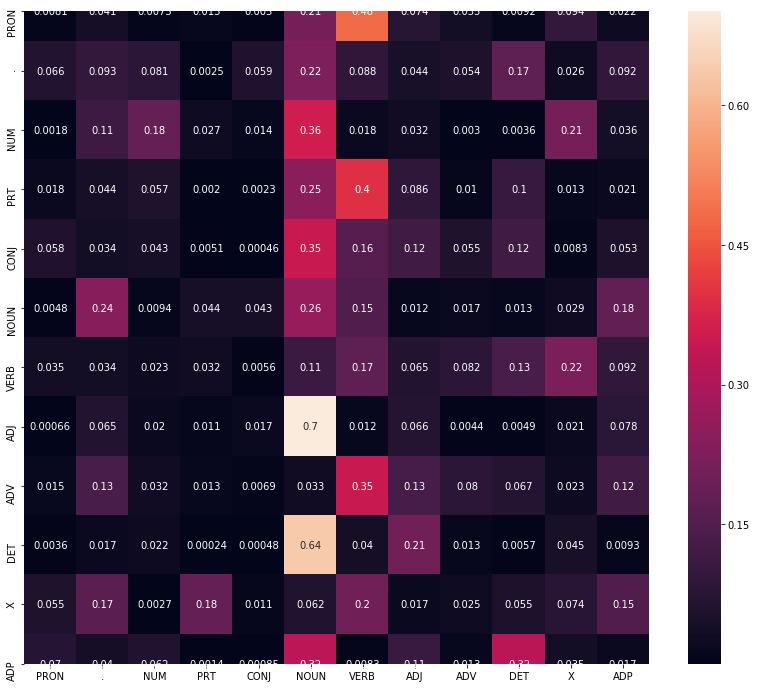

In [22]:
# heatmap of tags matrix
plt.figure(figsize=(14, 12))
sns.heatmap(df_tags, annot = True)
plt.show()

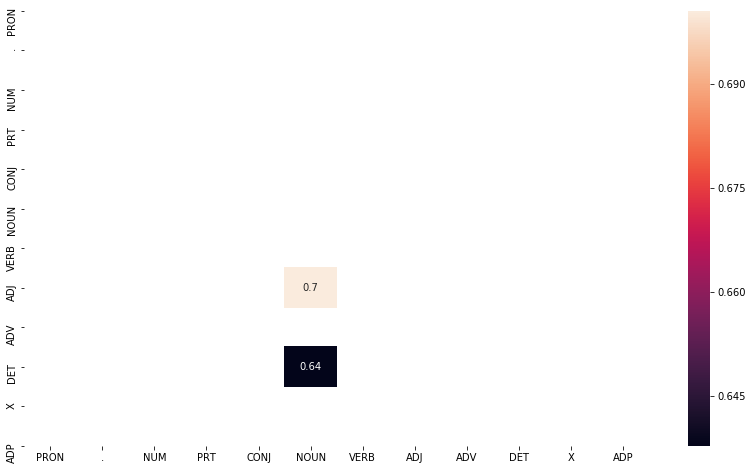

In [23]:
# frequent tags

frequent_tags = df_tags[df_tags > 0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(frequent_tags, annot = True)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'training_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [24]:
# Vanilla Viterbi Algorithm
def vanilla_viterbi(words, training_bag = training_tagged_words):
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    T = list(set(get_tuple_value_from_list(training_bag, 1)))
        
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting maximum probability state
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Testing Vanilla Viterbi Algorithm on sampled test data

In [25]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
# since running it on the entire data set will take many hours

random.seed(1234)

# tagged words
tagged_words = get_nested_tuple_from_list(test_set, -1)

# untagged words
test_tagged_words = get_nested_tuple_from_list(test_set, 0)

In [26]:
# tagging the test sentences
start = time.time()
test_tagged_seq = vanilla_viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [27]:
print("Time taken in seconds: ", difference)
print(test_tagged_seq)

Time taken in seconds:  1485.1158061027527
[('A', 'DET'), ('faster', 'ADJ'), ('version', 'NOUN'), (',', '.'), ('the', 'DET'), ('SuperDot', 'NOUN'), (',', '.'), ('was', 'VERB'), ('launched', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.'), ('William', 'NOUN'), ('R.', 'NOUN'), ('Breakey', 'PRON'), ('M.D.', 'NOUN'), ('Pamela', 'NOUN'), ('J.', 'NOUN'), ('Fischer', 'PRON'), ('M.D.', 'NOUN'), ('Department', 'NOUN'), ('of', 'ADP'), ('Psychiatry', 'PRON'), ('Johns', 'PRON'), ('Hopkins', 'PRON'), ('University', 'NOUN'), ('School', 'NOUN'), ('of', 'ADP'), ('Medicine', 'NOUN'), ('Baltimore', 'NOUN'), ('The', 'DET'), ('scammers', 'NOUN'), ('themselves', 'PRON'), ('were', 'VERB'), ('garden-variety', 'PRON'), ('low', 'ADJ'), ('lifes', 'PRON'), (',', '.'), ('conspicuous', 'ADJ'), ('consumers', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('wanted', 'VERB'), ('big', 'ADJ'), ('houses', 'NOUN'), (',', '.'), ('Mercedes', 'PRON'), ('cars', 'NOUN'), (',', '.'), ('beautiful', 'ADJ'), ('women'

In [28]:
# accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(test_tagged_seq, tagged_words) if i == j]

vanilla_viterbi_accuracy = len(check)/len(test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is :", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is : 0.9084317381396313


In [29]:
# understand the incorrect tagged cases

incorrect_tagged_cases = [[tagged_words[i-1],j] for i, j in enumerate(zip(test_tagged_seq, tagged_words)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
#incorrect_tagged_cases

442


####  Unknows words


In [30]:
# Unknown words 

test_vocab_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocab_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 317


Unknown Words : ['agriculture', 'COMMUNICATIONS', '37-year-old', '*T*-214', 'vetoes', 'upsetting', 'demonstrating', 'vision', 'Symbol', 'capitalism', 'Nelms', 'pair', 'Johns', 'accrued', 'depression', '301', 'ingenuity', 'scams', 'Dean', 'Eveready', 'Crime', 'Psychiatry', 'water-authority', 'destroy', 'copyrights', 'authorizing', '4.55', 'asbestosis', 'Petersburg', 'newspaper-printing', 'Encouraging', 'raw', 'HUD', 'hauling', 'reversed', 'logo', '51-year-old', 'Sonny', 'T-shirts', 'Trans', 'decisive', 'Leon', 'confident', '*T*-200', 'minimal', 'Level', 'ranging', 'clipped', 'money-center', 'Guarantee', 'characteristics', 'EST', 'stare', 'wheel-loader', 'reasserts', 'clothes', 'valuations', 'Something', 'fattened', 'Westport', 'fizzled', '*T*-107', 'protocols', '11,390,000', 'enjoyed', 'comfortable', 'tinker', '6.4', 'trials', 'deteriorating', 'coal-fired', 'snaking', 'coincidental', 'quietly', 'Brent', 'Baim', 'dismissal', '5.6', 'inheritor', 'Post', '7.79',

### Solve the problem of unknown words

#### Method 1 

Method 1
The default Vanilla viterbi algorithm achieved an accuracy of about 94.14%. This approx. 5.86% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the vanilla viterbi.

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below -

If word in unknown then

consider only the transition_p (emission probability being 0)

else

consider both the emission and transition probability.

In [31]:
# Modified Viterbi Heuristic for Unknown words
def Unknown_Words_With_Vanilla_Viterbi(words, training_bag = training_tagged_words):
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    T = list(set(get_tuple_value_from_list(training_bag, 1)))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# tagging the test sentences
start = time.time()
unknown_word_test_tagged_seq = Unknown_Words_With_Vanilla_Viterbi(test_tagged_words)

# accuracy
test_unknown_word_check = [i for i, j in zip(unknown_word_test_tagged_seq, tagged_words) if i == j]

optimized_viterbi_accuracy = len(test_unknown_word_check)/len(unknown_word_test_tagged_seq)

end = time.time()
difference = end-start

In [33]:
print("Time taken in seconds: ", difference)
print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is:", optimized_viterbi_accuracy)

Time taken in seconds:  1414.5396857261658
The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is: 0.9428216283405843


The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is: 0.9377224199288257
We see the modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) 94 comapred to 94% of the vanilla viterbi.

Still there is a loss of approx. 6%.

Now lets see if we can in reduce this loss further.

Let's try with some Lexicon and Rule-Based Models for POS Tagging.
Unigram Tagger

In [34]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("Unigram Tagger Accuracy: ", unigram_tagger_accuracy)

Unigram Tagger Accuracy:  0.9071887300600787


Let's now try combining the unigram tagger with a rule based regex tagger.

In [35]:
# rule based regex tagger

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [36]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

In [37]:
print("Unigram Tagger Accuracy backed up by the RegexpTagger:", accuracy_rule_based_unigram_tagger)

Unigram Tagger Accuracy backed up by the RegexpTagger: 0.939714108141703


In [38]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)

In [39]:
print("Bigram Tagger Accuracy backed up by the rule based unigram tagger:", accuracy_bigram_tagger)

Bigram Tagger Accuracy backed up by the rule based unigram tagger: 0.943857468406878


In [40]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)

In [41]:
print("Trigram Tagger accuracy backed up by the bigram tagger:", accuracy_trigram_tagger)

Trigram Tagger accuracy backed up by the bigram tagger: 0.941371452247773


##### Method 2
We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.6%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [42]:

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [43]:
def viterbi_backedup_by_trigram_tagger(words, training_bag = training_tagged_words):
    state = []
    tag_set = list(set(get_tuple_value_from_list(training_bag, 1))) #list(set([pair[1] for pair in training_bag]))
    
    # unknown words with trigram tagger backed up by the rule based tagger

    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = df_tags.loc['.', tag]
                else:
                    transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [44]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, tagged_words) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

In [45]:
print("viterbi backed up by trigram tagger accuracy:", viterbi_trigram_accuracy)

viterbi backed up by trigram tagger accuracy: 0.9604309094675783


#### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
##### 1. First lets check the tagging accuracy on the test_set data generated using the test_train_split

In [46]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

df_data_acccuracy = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

df_data_acccuracy.set_index('Tagging_Algorithm', drop = True, inplace = True)

df_data_acccuracy

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.843174
Optimized Vanilla Viterbi,94.282163
Unigram Tagger,90.718873
Unigram + RegexpTagger,93.971411
Bigram Tagger + Unigram_tagger,94.385747
Trigram Tagger + Bigram_tagger,94.137145
Viterbi + Trigram_tagger,96.043091


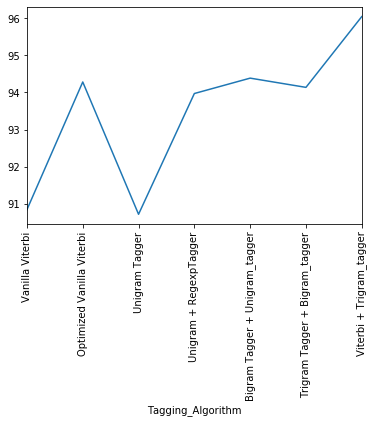

In [47]:
df_data_acccuracy.plot.line(rot = 90, legend = False)

#### 2. Next, lets check the tagging accuracies for the algorithm on the sample test sentences provided -

In [48]:
test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [49]:
test_tokenized_sents = [word_tokenize(sent) for sent in test_sentences]
test_corpus_pos_tags = nltk.pos_tag_sents(test_tokenized_sents, tagset = 'universal')
test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [50]:
# untagged words from the test data provided
test_tagged_words = get_nested_tuple_from_list(test_corpus_pos_tags, 0)

# tagged words
tagged_words_test_run_base  = get_nested_tuple_from_list(test_corpus_pos_tags, -1)

In [51]:
test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

#### 1. Testing the accuracy of Vanilla Viterbi on sample test data -

In [52]:
# tagging the test sentences
sample_data_test_tagged_seq = vanilla_viterbi(test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_data_test_check = [i for i, j in zip(sample_data_test_tagged_seq, tagged_words_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_data_test_check)/len(sample_data_test_tagged_seq)

In [53]:
print("Vanilla Viterbi Algorithm accuracy on the sample test data:", vanilla_viterbi_accuracy_on_sample_test_data)

Vanilla Viterbi Algorithm accuracy on the sample test data: 0.7513812154696132


#### 2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data -

In [54]:
# tagging the test sentences
sample_test_data_unknown_word_tagged_seq = Unknown_Words_With_Vanilla_Viterbi(test_tagged_words)

# accuracy
sample_test_data_unknown_word_check = [i for i, j in zip(sample_test_data_unknown_word_tagged_seq, tagged_words_test_run_base) if i == j]

sample_test_data_optimized_viterbi_accuracy = len(sample_test_data_unknown_word_check)/len(sample_test_data_unknown_word_tagged_seq)

In [55]:

print("Unknown_Words_With_Vanilla_Viterbi accuracy on the sample test data:", sample_test_data_optimized_viterbi_accuracy)

Unknown_Words_With_Vanilla_Viterbi accuracy on the sample test data: 0.8895027624309392


#### 3. Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data -

In [56]:
# tagging the test sentences
sample_test_data_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
sample_test_data_viterbi_trigram_check = [i for i, j in zip(sample_test_data_viterbi_trigram_tagged_seq, tagged_words_test_run_base) if i == j]

sample_test_data_viterbi_trigram_accuracy = len(sample_test_data_viterbi_trigram_check)/len(sample_test_data_viterbi_trigram_tagged_seq)

In [57]:
print("viterbi_backedup_by_trigram_tagger accuracy on the sample test data:", sample_test_data_viterbi_trigram_accuracy)

viterbi_backedup_by_trigram_tagger accuracy on the sample test data: 0.9281767955801105


The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_data_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_data_viterbi_trigram_accuracy*100]]

df_sample_test_data_acccuracy = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

df_sample_test_data_acccuracy.set_index('Tagging_Algorithm', drop = True, inplace = True)

df_sample_test_data_acccuracy

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.138122
Optimized Vanilla Viterbi,88.950276
Viterbi + Trigram_tagger,92.817680


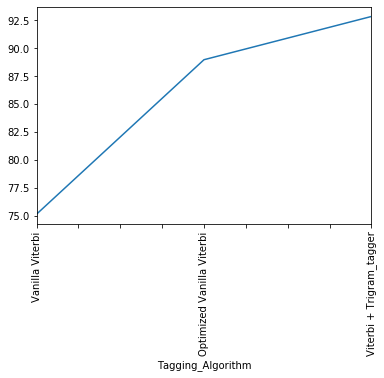

In [59]:
df_sample_test_data_acccuracy.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [60]:
# test sentences

test_data_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_data_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_data_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_data_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_data_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_data_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_data_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_data_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_data_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_data_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_data_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

#### Case - 1

In [61]:
# test_data_sentence_1 = 'Android is a mobile operating system developed by Google.'
# test_data_sentence_1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

words_test_data_sentence_2 = nltk.word_tokenize(test_data_sentence_2)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = vanilla_viterbi(words_test_data_sentence_2)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_data_sentence_2)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [62]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
df_tags_correction_1 = pd.DataFrame(columns = cols)
df_tags_correction_1 = df_tags_correction_1.fillna(0)

df_tags_correction_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
df_tags_correction_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

df_tags_correction_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, PRON)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, PRON)","(OS, NOUN)"
6,"(worldwide, PRON)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, PRON)","(smartphones, VERB)"
9,"(since, ADP)","(since, ADP)"


As we see above in the sample test sentence 1 the word 'Android' was tagged as PRT by vanilla viterbi. The modified algorithm of viterbi backed up by trigram tagger corrected this and tagged 'Android' as NOUN.

#### Case - 2

In [63]:
# test_data_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_data_sentence_6 = nltk.word_tokenize(test_data_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = vanilla_viterbi(words_test_data_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_data_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'PRON'), ('contested', 'PRON'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', '

In [64]:
df_tags_correction_6 = pd.DataFrame(columns = cols)
df_tags_correction_6 = df_tags_correction_6.fillna(0)

df_tags_correction_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
df_tags_correction_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

df_tags_correction_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, PRON)","(2018, NUM)"
2,"(FIFA, PRON)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, PRON)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, PRON)","(21st, NUM)"
8,"(FIFA, PRON)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


#### As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm - '2018' - PRT, 'FIFA' - PRT, 'Cup' - PRT, '21st' - PRT, 'tournament' - PRT, 'contested' - PRT.

#### The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.

#### Case - 3

In [65]:
# test_data_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_data_sentence_8 = nltk.word_tokenize(test_data_sentence_8)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = vanilla_viterbi(words_test_data_sentence_8)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_8)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_data_sentence_8)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_8)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'PRON'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [66]:
df_tags_correction_8 = pd.DataFrame(columns = cols)
df_tags_correction_8 = df_tags_correction_8.fillna(0)

df_tags_correction_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
df_tags_correction_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

df_tags_correction_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, PRON)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


##### As we see in the sample test sentence 8, the vanilla viterbi tagged 'trips' as PRT. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.
##### Now lets see the tags and corrections for all the sample test sentences with both the methods.
##### Method 1 - We used only the transition probability for unknown words.
##### Method 2 - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.¶

In [67]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_data_tagged_sequence_with_vanilla_viterbi = vanilla_viterbi(test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_data_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*125)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_data_tagged_sequence_unknown_words = Unknown_Words_With_Vanilla_Viterbi(test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_data_tagged_sequence_unknown_words)

print('\n')
print('-'*125)

# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_data_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", sample_test_data_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.'), ('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.'), ('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.'), ('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service

In [68]:
# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

df_tags_comparison = pd.DataFrame(columns = cols1)
df_tags_comparison = df_tags_comparison.fillna(0)

# Actual tags
df_tags_comparison.actual_tags = [tup for tup in tagged_words_test_run_base]

# tags by vanilla viterbi
df_tags_comparison.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_data_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
df_tags_comparison.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_data_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
df_tags_comparison.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_data_tagged_sequence_with_viterbi_trigram]

df_tags_comparison[df_tags_comparison.as_tagged_by_vanilla_viterbi != 
                   df_tags_comparison.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, PRON)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, PRON)","(Google, NOUN)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, PRON)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, PRON)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, PRON)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, PRON)","(smartphones, NOUN)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, PRON)","(2011, NOUN)","(2011, NUM)"
25,"(2013, NUM)","(2013, PRON)","(2013, NOUN)","(2013, NUM)"
27,"(Google, NOUN)","(Google, PRON)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, PRON)","(Twitter, NOUN)","(Twitter, NOUN)"


### Conclusion :
##### Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.
##### In this analysis we used 2 modification techniques for the original vanilla viterbi -

##### Method 1 -
- We used only the transition probability for unknown words.
- This method showed an increase in the accuracy (94.4%) but still had some incorrect classification.

- The accuracy could be increased further and we turned two a second modification in method-2 below.

##### Method 2 -
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- This gave us an accuracy of 95.82% on the test data.
- Also on testing this model on the provided sample test data, it achieved an accuracy of 92.81% and comes out to be 
the winner.